# Atacando un problema de clasificación: predicción de días lluviosos (segunda parte)



# ¿Qué pasa si los datos no están normalizados?

Empezamos igual que en el notebook anterior, cargando los datos de INTA.

In [ ]:
# Como siempre, tratamos de traer todos los paquetes al ppio
from google.colab import drive # Para montar nuestro drive en la consola
import matplotlib.pylab as plt # Para gráficos
import numpy as np # Para manejo de arrays, operaciones matemáticas, etc.
from sklearn.linear_model import LogisticRegression # El método de regresión logística que vamos a usar
import pandas as pd # Para manejo de base de datos
from sklearn.metrics import confusion_matrix # matriz de confusion

# Traemos los datos
drive.mount('/content/drive') # Montamos nuestra unidad de Google Drive

filename = '/content/drive/My Drive/LaboDatos2021/datosDiariosSanFernandoINTA.xls'

d = pd.read_excel(filename) # Levantamos los datos, en este caso, con el método pd.read_excel
d.head() # Mostramos las primeras líneas, para darnos una idea

Mounted at /content/drive


,Fecha,Temperatura_Abrigo_150cm,Temperatura_Abrigo_150cm_Maxima,Temperatura_Abrigo_150cm_Minima,Temperatura_Intemperie_5cm_Minima,Temperatura_Intemperie_50cm_Minima,Temperatura_Suelo_5cm_Media,Temperatura_Suelo_10cm_Media,Temperatura_Inte_5cm,Temperatura_Intemperie_150cm_Minima,Humedad_Suelo,Precipitacion_Pluviometrica,Precipitacion_Cronologica,Precipitacion_Maxima_30minutos,Heliofania_Efectiva,Heliofania_Relativa,Tesion_Vapor_Media,Humedad_Media,Humedad_Media_8_14_20,Rocio_Medio,Duracion_Follaje_Mojado,Velocidad_Viento_200cm_Media,Direccion_Viento_200cm,Velocidad_Viento_1000cm_Media,Direccion_Viento_1000cm,Velocidad_Viento_Maxima,Presion_Media,Radiacion_Global,Horas_Frio,Unidades_Frio
0,2018-02-08 00:00:00.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,79.0,NaN,NaN,NaN,,NaN,,NaN,NaN,NaN,NaN,NaN
1,2018-02-09 00:00:00.0,23.80764,28.6,20.4,NaN,NaN,NaN,26.21042,NaN,NaN,NaN,11.75,11.75,5.75,NaN,NaN,19.25281,66.0,73.0,16.462780,NaN,1.332639,C,1.665799,C,19.3,NaN,NaN,0.0,-23.904030
2,2018-02-10 00:00:00.0,24.51389,31.7,19.4,NaN,NaN,NaN,26.45972,NaN,NaN,NaN,10.50,0.00,0.00,NaN,NaN,23.28392,72.0,77.0,18.622350,NaN,1.638195,C,2.047743,C,19.0,NaN,NaN,0.0,-23.904030
3,2018-02-11 00:00:00.0,19.50139,24.2,15.1,NaN,NaN,NaN,24.66320,NaN,NaN,NaN,0.00,10.50,4.00,NaN,NaN,14.67725,65.0,67.0,12.071650,NaN,3.247224,E,4.059030,C,20.4,NaN,NaN,0.0,-15.106020
4,2018-02-12 00:00:00.0,16.70625,24.6,9.5,NaN,NaN,NaN,22.63611,NaN,NaN,NaN,0.25,0.00,0.00,NaN,NaN,13.13446,66.0,69.0,9.627476,NaN,1.027778,C,1.284722,C,13.4,NaN,NaN,0.0,-5.394994


Luego, selecciono un subconjunto de columnas, las renombro y me deshago de los datos faltantes.

In [ ]:
d_filtrado = d[['Temperatura_Abrigo_150cm_Maxima',
                'Temperatura_Abrigo_150cm_Minima',
                'Precipitacion_Pluviometrica',
                'Velocidad_Viento_Maxima',
                'Rocio_Medio',
                'Humedad_Media']].dropna().copy() # Nos quedamos con ciertos campos del data set, para facilitar el trabajo. Y para limitarlo.
                                                  # Notar que primero aplicamos el método .dropna() para eliminar filas que tengan alguna columna con NaN 
                                                  # Ademas, el metodo copy() nos asegura que estemos creando un nuevo dataframe 
d_filtrado.rename({'Temperatura_Abrigo_150cm_Maxima' : 'temperaturaMaxima',
                   'Temperatura_Abrigo_150cm_Minima' : 'temperaturaMinima',
                   'Precipitacion_Pluviometrica' : 'precipitacion',
                   'Humedad_Media' : 'humedad',
                   'Rocio_Medio' : 'rocio',
                   'Velocidad_Viento_Maxima' : 'viento'},
                  axis = 1,
                  inplace = True) # Esto toma como input un diccionario en el cual las llaves son los nombres actuales de columnas, y los valores los nombres nuevos (a los que queremos renombrar)
                                  # axis = 1 es porque queremos renombrar columnas, y inplace=True es porque queremos "pisar" el dataframe al renombrarlo

Creo una nueva columna que contiene la etiqueta que indica si llueve o no llueve.

In [ ]:
d_filtrado['llueveNollueve'] = 0 # empezamos con una columna llena de 0. 
indice =  d_filtrado['precipitacion'] > 0  # esto me da los valores del indice para los cuales hay precipitacion mayor a 0
d_filtrado.loc[indice, 'llueveNollueve'] = 1 # entonces para esos valores del indice pongo 1, porque en el dia correspondiente, llovio

d_filtrado['llueveNollueve'].value_counts()

0    717
1    337
Name: llueveNollueve, dtype: int64

Aqui vuelvo a definir las funciones que defini en el notebook anterior, que sirven para graficar y para calcular la balanced accuracy.

In [ ]:
def grafica_logred_2D(X,y,regLog):

  beta_0 = regLog.intercept_ # El beta 0
  beta_1 = regLog.coef_[0][0] # El coeficiente beta_1
  beta_2 = regLog.coef_[0][1] # El coeficiente beta_2

  fig, ax = plt.subplots(figsize = (10,7))

  ax.set_title('Mi Regresión Logística')
  ax.scatter(X[:,0], # Ploteamos la primera columna de nuestra matriz X. Osea, la temperaturaMinima
            X[:,1], # Ploteamos la segunda columna de nuestra matriz X. Osea, la humedad
            c = y, # Les damos color a los puntos según la etiqueta real
            cmap = 'Set3', # El mapa de color
            )
  ax.set_xlabel('Temperatura Mínima') # Etiqueta del eje x
  ax.set_ylabel('Humedad') # Etiqueta del eje y

  # Plotear la curva acá, no sería de mucho interés. Sí podríamos colorear un área como representación de la función P: R² ---> R
  # Plotiemos la frontera de decisión

  x_1_test = np.arange(-20,30,0.5) # Generamos unas temperaturas de prueba, para plotear la definición de frontera en el caso de dos features como vimos en la teórica
  ax.plot(x_1_test,
          - (beta_0 + x_1_test * beta_1) / beta_2, # Generamos el la recta que calculamos en la teórica
          linestyle = 'dashed',
          color = 'k')
  #ax.legend()
  ax.axis([min(X[:,0]),max(X[:,0]),min(X[:,1]),max(X[:,1])]) # Seteamos los límites de los ejes
  plt.show()



def balanced_accuracy(cm): # funcion para calcular la "balanced accuracy"
  sensibilidad = cm[1,1]/(cm[1,1]+cm[0,1])
  especificidad = cm[0,0]/(cm[1,0]+cm[0,0])
  return [sensibilidad, especificidad, (sensibilidad + especificidad)/2]

Ahora vamos a usar las variables de temperatura maxima y humedad

(1054, 2)
El score del modelo es de: 0.667
Matriz de confusion del modelo es:
[[479 113]
 [238 224]]
Sensibilidad del modelo es de: 0.6647
Especificidad del modelo es de: 0.6681
BA del modelo es de: 0.6664


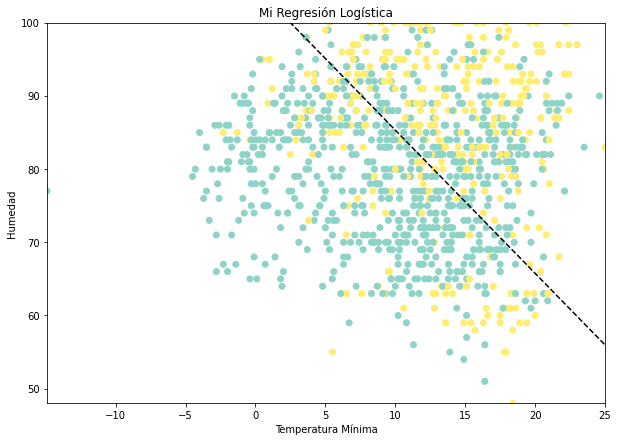

In [ ]:
# Definamos la matriz X
campos = ['temperaturaMinima',
          'humedad'] # Lista que contiene las features de interés. En este caso, son temperatura mínima y humedad
X = d_filtrado[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
print(X.shape) # Como vemos, es una matriz de 1054 filas y 2 columnas
y = d_filtrado['llueveNollueve'] # Nuestra etiqueta sigue siende la misma de antes

regLog = LogisticRegression(penalty = 'none', class_weight='balanced') # Inicializamos nuevamente el modelo
regLog.fit(X, y) # Ajustamos el modelo con los parámetros
score = regLog.score(X,y) # Calculamos el score
beta_0 = regLog.intercept_ # El beta 0
beta_1 = regLog.coef_[0][0] # El coeficiente beta_1
beta_2 = regLog.coef_[0][1] # El coeficiente beta_2

ypred = regLog.predict(X) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm = confusion_matrix(ypred, y) # primera entrada son las etiquetas predichas, segunda son las reales
metricas = balanced_accuracy(cm)

print('El score del modelo es de: {}'.format(round(score,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4))) 

grafica_logred_2D(X,y,regLog)

Podemos graficar histogramas para verificar que el rango de valores que toman estas variables es muy similar, por lo tanto no tengo un problema de escalas diferentes en mis variables.

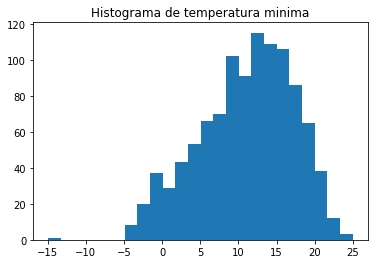

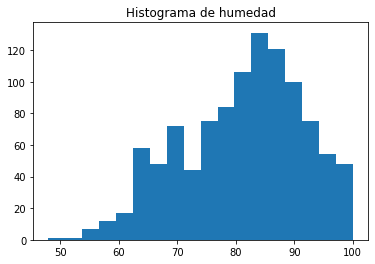

In [ ]:
plt.hist(X[:,0], bins='auto')  # construimos histograma para la primera variable, con bines seleccionados automáticamente
plt.title("Histograma de temperatura minima") # ponemos titulo
plt.show() # mostrar!

plt.hist(X[:,1], bins='auto')  # construimos histograma para la segunda variable, con bines seleccionados automáticamente
plt.title("Histograma de humedad") # ponemos titulo
plt.show() # mostrar!

Ahora, podemos suponer que los datos de humedad estaban en una unidad diferente, por ejemplo, una unidad que resulta en multiplicar por 1000, y ahi serian bien distintos los rangos de valores de las columnas.
Observamos el ejemplo de multiplicar por 1000 la columna de la humedad:

In [ ]:
# Definamos la matriz X
campos = ['temperaturaMinima',
          'humedad'] # Lista que contiene las features de interés
X = d_filtrado[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos

X[:,1] = 1000*X[:,1] # supongamos que cambiamos las unidades con las que medimos la humedad

regLog = LogisticRegression(penalty = 'none', class_weight='balanced') # Inicializamos nuevamente el modelo
regLog.fit(X, y) # Ajustamos el modelo con los parámetros
score = regLog.score(X,y) # Calculamos el score
beta_0 = regLog.intercept_ # El beta 0
beta_1 = regLog.coef_[0][0] # El coeficiente beta_1
beta_2 = regLog.coef_[0][1] # El coeficiente beta_2

ypred = regLog.predict(X) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm = confusion_matrix(ypred, y) # primera entrada son las etiquetas predichas, segunda son las reales
metricas = balanced_accuracy(cm)

print('El score del modelo es de: {}'.format(round(score,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4))) 



El score del modelo es de: 0.3197
Matriz de confusion del modelo es:
[[  0   0]
 [717 337]]
Sensibilidad del modelo es de: 1.0
Especificidad del modelo es de: 0.0
BA del modelo es de: 0.5


Vemos que la performance del modelo cae drasticamente. Esto es claramente un problema: si me hubiesen dado los datos con la humedad medida en esta unidad, hubiese tenido problemas para alcanzar una performance mínimamente aceptable.



# ¿Cómo puedo asegurarme de trabajar con datos normalizados?

Por suerte, scikit-learn viene con funciones que sirven para normalizar y estandarizar datos. Son las siguientes:

```
sklearn.preprocessing.MinMaxScaler

sklearn.preprocessing.StandardScaler
```

La primera implementa el escaleo MinMax, escaleando todas la variables en el intervalo [0,1]. La segunda transforma las variables a sus z-scores.

Vamos a normalizar la matriz de features X, usando la primera de estas dos funciones.






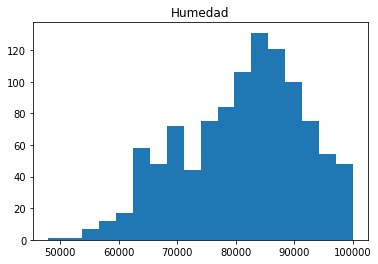

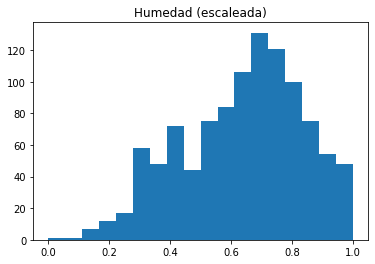

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X) # encuentro los parametros para el escaleo
X_scale = scaler.transform(X) # aplico la transformacion

plt.hist(X[:,1], bins='auto')  
plt.title("Humedad")
plt.show()

plt.hist(X_scale[:,1], bins='auto')  
plt.title("Humedad (escaleada)")
plt.show()


Finalmente, observo que recupero la performance si ahora entreno la regresión logística con los datos re-escaleados.

In [ ]:
regLog = LogisticRegression(penalty = 'none', class_weight='balanced') # Inicializamos nuevamente el modelo
regLog.fit(X_scale, y) # Ajustamos el modelo con los parámetros
score = regLog.score(X_scale,y) # Calculamos el score

ypred = regLog.predict(X_scale) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm = confusion_matrix(ypred, y) # primera entrada son las etiquetas predichas, segunda son las reales
metricas = balanced_accuracy(cm)

print('El score del modelo es de: {}'.format(round(score,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4))) 

El score del modelo es de: 0.667
Matriz de confusion del modelo es:
[[479 113]
 [238 224]]
Sensibilidad del modelo es de: 0.6647
Especificidad del modelo es de: 0.6681
BA del modelo es de: 0.6664


#  Para llevarse de este notebook

*   Es buena práctica visualizar mis variables numéricas antes de entrenar un clasificador. Por ejemplo, podemos hacer histogramas. De esta forma, si una variable tiene un rango mucho más distinto que las demás, podemos identificarla.

*   La performance del algoritmo puede estar influenciada por estas diferencias de escala. Esto no sucede para todos los algoritmos de machine learning, pero sí sucede para muchos. Por eso, siempre es buena idea estandarizar o normalizar los datos.

*   El proceso de normalizar o estandarizar los datos es similar a lo que venimos viendo en scikit-learn. Primero creo un objeto, luego estimo sus parámetros, y finalmente los aplico para transformar los datos.

```
scaler = MinMaxScaler() 
scaler.fit(X) 
X_scale = scaler.transform(X) 
```

... y lo mismo para la estandarización.





# Preguntas extra


*   **¿Qué pasa si yo entreno el MinMaxScaler con datos X, y luego uso el método .transform en otros datos distintos Y? ¿Puedo asegurar que las variables en la matriz Y también van a estar necesariamente entre [0,1]?**

*   ¿En qué situación puede convenir usar más la conversión a z-scores en vez del escaleo MinMax?

*   Ir cambiando el factor multiplicativo 1000 para tener una idea de en qué momento la diferencia entre el rango de las variables empieza a afectar la performance del clasificador.



